# Praktikum 1 - RNN untuk Analisis Sentimen

## Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
      plt.plot(history.history[metric])
      plt.plot(history.history['val_'+metric], '')
      plt.xlabel("Epochs")
      plt.ylabel(metric)
      plt.legend([metric, 'val_'+metric])

## Setup Pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Great voices, lots of adventure and clever dialogue make this a very good movie. The addition of "character" to the three lead animals gives the story a lot more depth and meaning, particularly the relationship between the older fellow, Shadow, and the young hellraiser, Chance. The earlier versions of this film were unable to give the animals any real personality or motive, which is done perfectly here. Sally Field is lovable in anything, but really shines in this film as the proud feline, Sassy. Great contrast between cat and dog perspectives on life, and just the right amount of spirit and warm fuzzies to make the plot and resolution excellent. There\'s even an uplifting score and beautiful mountain scenery. Definitely perfect for an evening alone or with the kids. Hats off to Disney.'
 b"This movie catches a lot of flak, but this is usually based on the horrible looking and covered / clothed version of the film that played US television and has also been issued to death o

## Text Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 85,   1, 741, ...,   0,   0,   0],
       [ 11,  18,   1, ...,   0,   0,   0],
       [ 21,   1,   1, ..., 148,   6, 209]])

In [9]:
for n in range(3):
      print("Original: ", example[n].numpy())
      print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
      print()

Original:  b'Great voices, lots of adventure and clever dialogue make this a very good movie. The addition of "character" to the three lead animals gives the story a lot more depth and meaning, particularly the relationship between the older fellow, Shadow, and the young hellraiser, Chance. The earlier versions of this film were unable to give the animals any real personality or motive, which is done perfectly here. Sally Field is lovable in anything, but really shines in this film as the proud feline, Sassy. Great contrast between cat and dog perspectives on life, and just the right amount of spirit and warm fuzzies to make the plot and resolution excellent. There\'s even an uplifting score and beautiful mountain scenery. Definitely perfect for an evening alone or with the kids. Hats off to Disney.'
Round-trip:  great [UNK] lots of [UNK] and [UNK] dialogue make this a very good movie the [UNK] of character to the three lead [UNK] gives the story a lot more [UNK] and [UNK] particularly

## Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[-0.00133722]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 68ms/step
[-0.00133722]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 109ms/step - loss: 0.6428 - accuracy: 0.5601 - val_loss: 0.5174 - val_accuracy: 0.7490
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.4567 - accuracy: 0.7898 - val_loss: 0.3886 - val_accuracy: 0.8328
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3616 - accuracy: 0.8401 - val_loss: 0.3498 - val_accuracy: 0.8401
Epoch 4/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3322 - accuracy: 0.8565 - val_loss: 0.3324 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3175 - accuracy: 0.8626 - val_loss: 0.3312 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3124 - accuracy: 0.8654 - val_loss: 0.3277 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3082 - accuracy: 0.8661 - val_loss: 0.3453 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3149 - accuracy: 0.8563
Test Loss: 0.3148864507675171
Test Accuracy: 0.8563200235366821


(0.0, 0.6599059119820595)

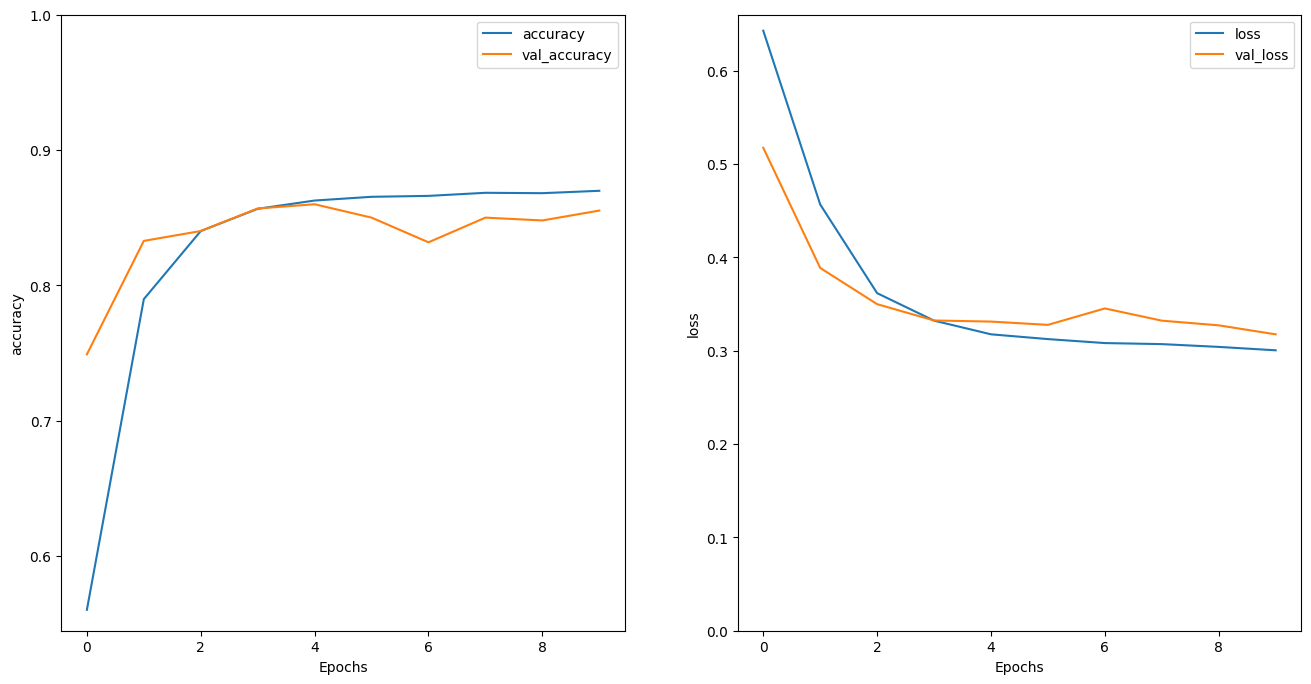

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),tf.keras.layers.Dense(64, activation='relu'),tf.keras.layers.Dropout(0.5),tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 161ms/step - loss: 0.6401 - accuracy: 0.5784 - val_loss: 0.5047 - val_accuracy: 0.7594
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.4228 - accuracy: 0.8168 - val_loss: 0.3740 - val_accuracy: 0.8375
Epoch 3/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3467 - accuracy: 0.8552 - val_loss: 0.3404 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3272 - accuracy: 0.8622 - val_loss: 0.3323 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3133 - accuracy: 0.8684 - val_loss: 0.3266 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3095 - accuracy: 0.8701 - val_loss: 0.3224 - val_accuracy: 0.8531
Epoch 7/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3035 - accuracy: 0.8725 - val_loss: 0.3248 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3169 - accuracy: 0.8628
Test Loss: 0.3169291913509369
Test Accuracy: 0.8628399968147278


[](http://)

In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.5583755]]


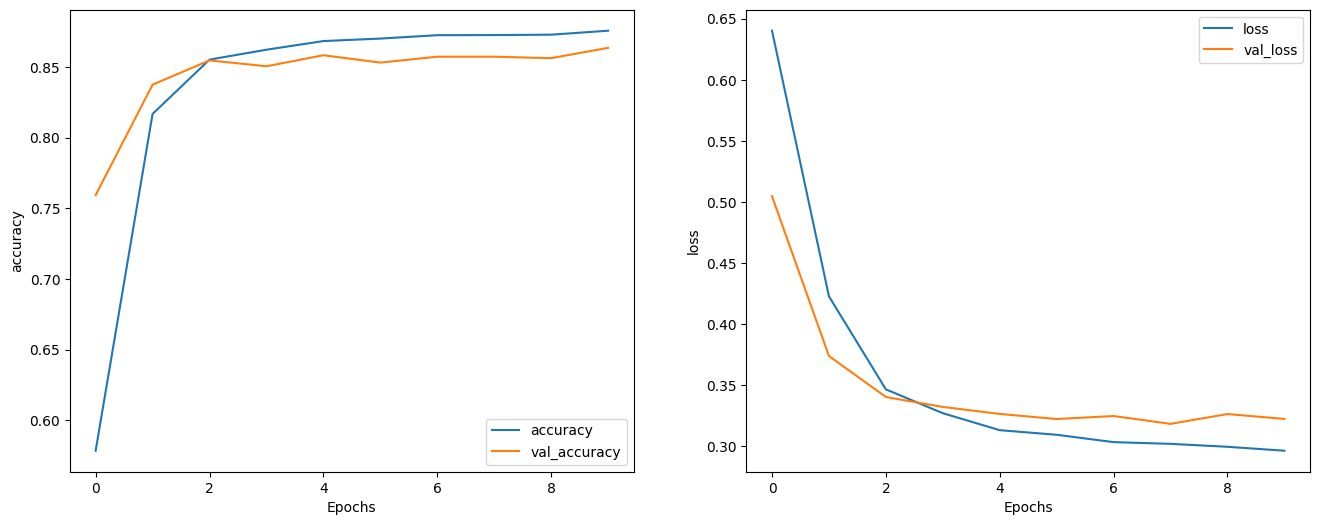

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')